# Phase from trio

In [3]:
import random
import vcf
import collections

In [2]:
def output_SNP():
    alphabet = ["A", "T", "G", "C"]
    pos = [random.randint(0, len(alphabet) - 1) for i in range(2)]
    return [alphabet[i] for i in pos]

In [3]:
def create_genome(snp_length):
    genome = []
    for i in range(snp_length):
        genome.append(output_SNP())
    return genome

In [4]:
def cross_over(length):
    start = random.randint(0, 1)
    switch_over = random.randint(0, length - 1)
    selection = [start]
    for i in range(length - 1):
        if i < switch_over:
            selection.append(start)
        else:
            selection.append(int(not start))
    return selection

In [5]:
def apply_cross_over(cross_over, genome):
    return [genome[i][j] for i, j in zip(range(len(genome)), cross_over)]

In [6]:
def dephase(genome):
    dephased_genome = []
    for snp in genome:
        new_snp = [i for i in snp]
        random.shuffle(new_snp)
        dephased_genome.append(new_snp)
    return dephased_genome

In [7]:
def reproduce(genome1, genome2):
    co1 = cross_over(len(genome1))
    co2 = cross_over(len(genome2))
    haplo1 = apply_cross_over(co1, genome1)
    haplo2 = apply_cross_over(co2, genome2)
    return [list(k) for k in zip(haplo1, haplo2)]

In [8]:
length = 6

genome1 = create_genome(length)
genome2 = create_genome(length)
offspring = reproduce(genome1, genome2)

dephased_genome1 = dephase(genome1)
dephased_genome2 = dephase(genome2)
dephased_offspring = dephase(offspring)

In [9]:
genome1

[['T', 'G'], ['C', 'T'], ['G', 'A'], ['G', 'G'], ['T', 'C'], ['C', 'T']]

In [10]:
genome2

[['G', 'A'], ['T', 'A'], ['A', 'G'], ['C', 'A'], ['G', 'A'], ['C', 'A']]

In [11]:
offspring

[['T', 'A'], ['C', 'A'], ['G', 'G'], ['G', 'A'], ['C', 'A'], ['T', 'C']]

In [12]:
print(genome1)
print(genome2)
print(offspring)

[['T', 'G'], ['C', 'T'], ['G', 'A'], ['G', 'G'], ['T', 'C'], ['C', 'T']]
[['G', 'A'], ['T', 'A'], ['A', 'G'], ['C', 'A'], ['G', 'A'], ['C', 'A']]
[['T', 'A'], ['C', 'A'], ['G', 'G'], ['G', 'A'], ['C', 'A'], ['T', 'C']]


In [13]:
def phase_offspring(genome1, genome2, offspring):
    possibilities = []
    phased_offspring = []
    for snp_o, snp_g1, snp_g2 in zip(offspring, genome1, genome2):
        snp_o = [i for i in snp_o]
        possibility = [[], []]
        for k in range(0, 2):
            if snp_o[k] in snp_g1:
                possibility[k].append(0)
            if snp_o[k] in snp_g2:
                possibility[k].append(1)
        possibilities.append(possibility)
        if possibility[0] == [0] or possibility[1] == [1]:
            phased_offspring.append(snp_o + ["|"])
        elif possibility[1] == [0] or possibility[0] == [1]:
            phased_offspring.append(snp_o[::-1] + ["-|"])
        else:
            phased_offspring.append(snp_o + ["?"])
    return phased_offspring

In [14]:
print(genome1)
print(genome2)
print(offspring)

[['T', 'G'], ['C', 'T'], ['G', 'A'], ['G', 'G'], ['T', 'C'], ['C', 'T']]
[['G', 'A'], ['T', 'A'], ['A', 'G'], ['C', 'A'], ['G', 'A'], ['C', 'A']]
[['T', 'A'], ['C', 'A'], ['G', 'G'], ['G', 'A'], ['C', 'A'], ['T', 'C']]


In [15]:
phase_offspring(dephased_genome1, dephased_genome2, dephased_offspring)

[['T', 'A', '|'],
 ['C', 'A', '-|'],
 ['G', 'G', '?'],
 ['G', 'A', '|'],
 ['C', 'A', '|'],
 ['T', 'C', '-|']]

# Load data from the Jewish trio

In [26]:
def load_vcf(filename, limit=-1, chrom_limit="", phased=False):
    genotype = {}
    for i, record in enumerate(vcf.Reader(filename=filename)):
        if record.CHROM == chrom_limit:
            break
        if i == limit:
            break
        snp = record.samples[0].gt_bases
        if record.samples[0].phased:
            a, b = snp.split("|")
        else:
            a, b = snp.split("/")
        if phased and record.samples[0].phased or not phased:
            genotype[(record.CHROM, record.POS)] = a, b
    return genotype

In [17]:
son = load_vcf("son_jewish.vcf", chrom_limit="chr2")

Allele number not found in list of alleles


AttributeError: 'NoneType' object has no attribute 'split'

In [407]:
mother = load_vcf("mother_jewish.vcf", chrom_limit="chr2")

In [408]:
father = load_vcf("father_jewish.vcf", chrom_limit="chr2")

In [409]:
son_genome = []
father_genome = []
mother_genome = []
shared_SNPs = sorted(list(set(son).intersection(set(mother)).intersection(set(father))))
for chr_coord in shared_SNPs:
    son_genome.append(son[chr_coord])
    father_genome.append(father[chr_coord])
    mother_genome.append(mother[chr_coord])

In [410]:
collections.Counter([i[0] for i in shared_SNPs])

Counter({'chr1': 170171})

In [411]:
r = [i[1] for i in shared_SNPs if i[0] == "chr1"]

In [412]:
length = r[-1] - r[0]

In [413]:
length

248097755

# Average distance per SNP

In [17]:
length/len(r)

NameError: name 'r' is not defined

In [422]:
phased_genome = phase_offspring(father_genome, mother_genome, son_genome)

['TACACACAC', 'T']
['TTG', 'TTGTG']
['A', 'AAC']
['C', 'CTT']
['C', 'CA']
['C', 'CTAAA']
['C', 'CT']
['T', 'TAC']
['CTTTA', 'C']
['G', 'GA']
['CTTATTTAT', 'C']
['GAGAG', 'C']
['TATAATA', 'T']
['A', 'AAATAATAAT']
['CAAAT', 'C']
['CTGTG', 'CTG']
['CA', 'C']
['A', 'AT']
['GTATTA', 'G']
['TTA', 'T']
['T', 'TACAC']
['T', 'TTGTGTGTGTG']
['C', 'CA']
['CTT', 'C']
['C', 'CGGGG']
['T', 'TGCC']
['A', 'AAAAATAAAATAAAATAAAAT']
['C', 'CA']
['CA', 'C']
['T', 'TACAC']
['A', 'AT']
['CCTTCCTTTCTTT', 'C']
['CTTTTTT', 'C']
['CT', 'C']
['T', 'TCAA']
['C', 'CTT']
['C', 'CAGAT']
['ATT', 'A']
['GACAA', 'G']
['ATGTG', 'A']
['T', 'TACAC']
['TCACACA', 'T']
['AAGAG', 'A']
['AT', 'A']
['A', 'AT']
['AT', 'A']
['GTTTT', 'G']
['T', 'TATAG']
['CCCTT', 'CCCTTCCTT']
['GACACAC', 'G']
['A', 'ATG']
['ATATCTATC', 'ATATC']
['GGTGTGT', 'G']
['CT', 'C']
['C', 'CTGTTGT']
['TGATAGATA', 'T']
['GTTA', 'G']
['A', 'AAT']
['AT', 'A']
['A', 'AT']
['A', 'ATG']
['C', 'CA']
['C', 'CA']
['C', 'CA']
['G', 'GACAC']
['AT', 'A']
['CA', 'C']
[

In [435]:
collections.Counter([i[-1] for i in phased_genome])

Counter({'?': 135010, '|': 34735, '-|': 426})

# Average distance per phasing-suitable SNP

In [17]:
length/collections.Counter([i[-1] for i in phased_genome])["|"]

NameError: name 'collections' is not defined

## This could potentially be a special case, with two reference alleles

```
['chr1', '2342840', '.', 'A', 'ATATTTTATTTTATTT,ATATTTTATTTTATTTTATTTTATTT', '50', 'PASS', 'platforms=1;platformnames=Illumina;datasets=2;datasetnames=HiSeqPE300x,HiSeq250x250;callsets=2;callsetnames=HiSeqPE300xSentieon,HiSeq250x250Sentieon;datasetsmissingcall=CGnormal,HiSeqPE300x,HiSeq250x250,10XChromium,HiSeqMatePair,IonExome,SolidSE75bp;callable=CS_HiSeqPE300xSentieon_callable,CS_HiSeq250x250Sentieon_callable;filt=CS_HiSeqPE300xfreebayes_filt;difficultregion=AllRepeats_51to200bp_gt95identity_merged', 'GT:DP:ADALL:AD:GQ:IGT:IPS:PS', '1/2:367:0,120,149:14,158,191:198:1|2:.:.']
```

In [1]:
def merge_record(old_record_str, new_record):
    s = old_record_str
    curr = 0
    peeled = []
    for elem in old_record_str.split():
        pos = s.find(elem)
        peeled.append(s[:pos])
        s = s[pos + len(elem):]
    to_collapse = []
    for i, j in zip(peeled, new_record):
        to_collapse.append(i)
        to_collapse.append(j)
    v = "".join(to_collapse) + s
    return v

In [2]:
def reverse_genotype(record_str):
    record = record_str.split()
    params = record[8].split(":")
    values = record[9].split(":")
    
    def reverse_GT(field):
        nonlocal record
        sep = "/"
        if sep not in field:
            sep = "|"
            if sep not in field:
                raise ValueError("GT issues with record: {}".format(record))

        a, b = field.split(sep)
        new_GT = "/".join([b, a])
        return new_GT, int(a), int(b)
    
    def reverse_field(field, a, b):
        elems = field.split(",")
        new_elems = [i for i in elems]
        new_elems[a] = elems[b]
        new_elems[b] = elems[a]
        return ",".join(new_elems)
    
    result = []
    for param, value in zip(params, values):
        if param in ["GT", "IGT"]:
            new_value, a, b = reverse_GT(value)
        elif param in ["ADALL", "AD"]:
            new_value = reverse_field(value, a, b)
        else:
            new_value = value
        result.append(new_value)
    new_record = [i for i in record]
    new_record[9] = ":".join(result)
    return merge_record(record_str, new_record)

# Test

In [3]:
test_record = "chr1	8303862	.	TCAAACAAACAAACAAACAAA	TCAAACAAACAAACAAA,T	50	PASS	platforms=2;platformnames=Illumina,10X;datasets=3;datasetnames=HiSeqPE300x,HiSeq250x250,10XChromium;callsets=5;callsetnames=HiSeqPE300xSentieon,HiSeq250x250Sentieon,HiSeqPE300xfreebayes,HiSeq250x250freebayes,10XSentieonhaplo;datasetsmissingcall=CGnormal,HiSeqMatePair,IonExome,SolidSE75bp;callable=CS_HiSeqPE300xSentieon_callable,CS_HiSeq250x250Sentieon_callable;filt=CS_HiSeqMatePairfreebayes_filt;difficultregion=AllRepeats_lt51bp_gt95identity_merged	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	2/1:508:0,73,102:0,128,144:297:2|1:.:."

In [4]:
new_test_record = reverse_genotype(reverse_genotype(test_record))
"/".join(test_record.split("|")) == "/".join(new_test_record.split("|"))

True

In [26]:
with open("son_jewish.vcf") as f:
    with open("reverse_son_jewish.vcf", "w") as g:
        for i, record in enumerate(f):
            if not record:
                g.write("")
            elif record and record[0] == "#":
                g.write(record)
            else:
                if random.randint(0, 1):
                    record = reverse_genotype(record)
                else:
                    record = reverse_genotype(reverse_genotype(record))
                g.write(record)

# Compare

In [8]:
phased_vcf = load_vcf("reverse_son_jewish_phased.vcf")

33592


In [29]:
golden_standard = load_vcf("son_jewish.vcf", phased=True)

In [217]:
positions = sorted(list(set(phased_vcf).intersection(set(golden_standard))))

In [218]:
len(positions)

28836

In [219]:
phase_errors = {}
for position in positions:
    correct = golden_standard[position]
    phase_errors[position] = phased_vcf[position] == correct

In [221]:
phase_errors_items = list(phase_errors.items())

In [222]:
import matplotlib.pyplot as plt

In [323]:
sparse_regions = 0

trials = 10000
lengths = []
fraction = []
for i in range(trials):
    left = random.randint(phase_errors_items[0][0][1], phase_errors_items[-1][0][1])
    window = 10**5
    selected_window = [(i[1], j) for i, j in phase_errors_items if i[0] == "chr22" if i[1] < left + window and left < i[1]]
    if len(selected_window) < 20:
        sparse_regions += 1
        continue
    x, y = zip(*selected_window)
    counter = collections.Counter(y)
    correct, incorrect = counter[True], counter[False]
    f = max([correct, incorrect])/(correct+incorrect)
    lengths.append(len(x))
    fraction.append(f)

In [328]:
sparse_regions

2943

In [334]:
sum(fraction)/len(fraction)

0.8494704338811687

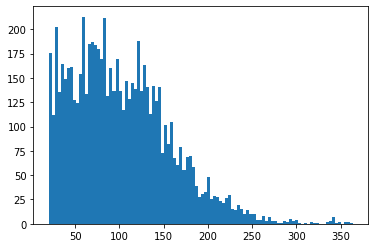

In [331]:
_ = plt.hist(lengths, bins=100)

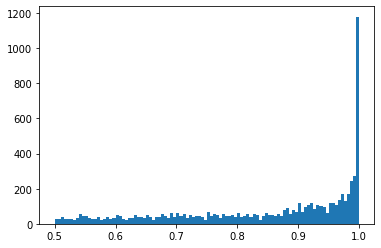

In [332]:
_ = plt.hist(fraction, bins=100)

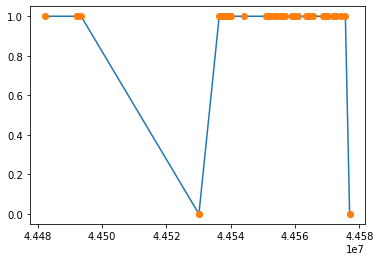

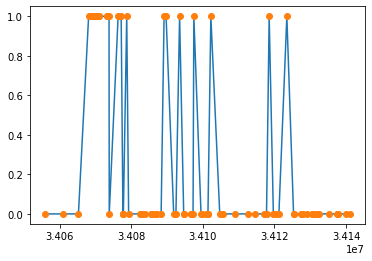

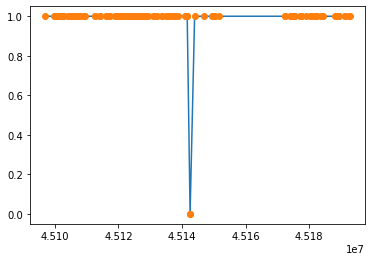

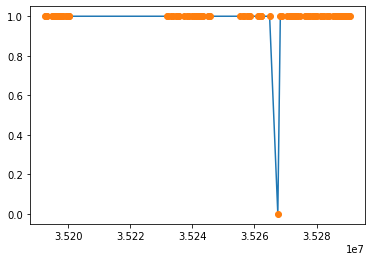

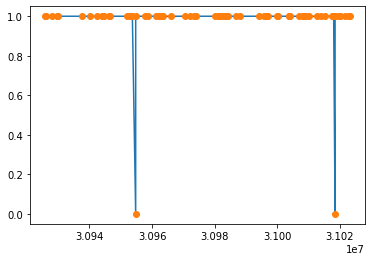

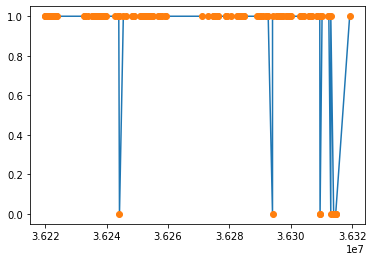

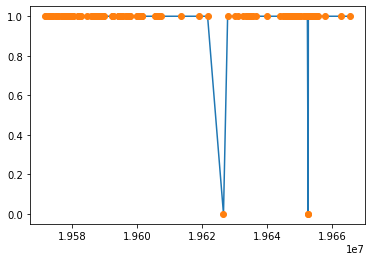

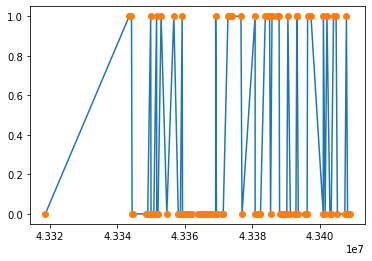

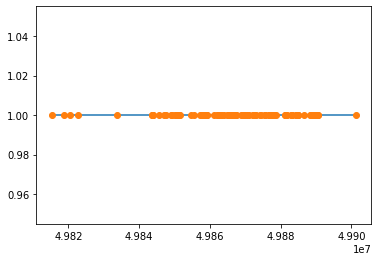

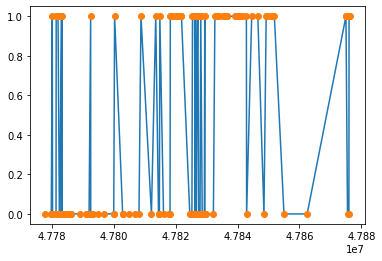

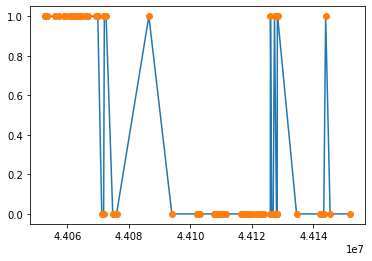

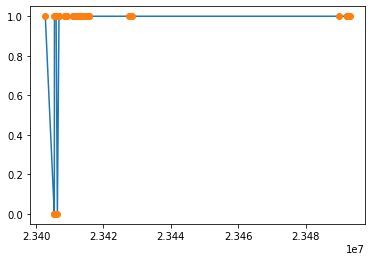

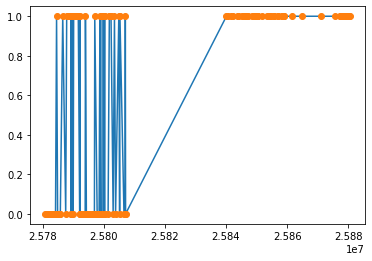

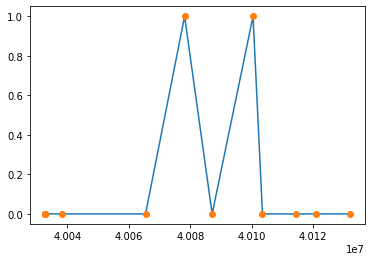

In [335]:
for i in range(20):
    left = random.randint(phase_errors_items[0][0][1], phase_errors_items[-1][0][1])
    window = 10**5
    selected_window = [(i[1], j) for i, j in phase_errors_items if i[0] == "chr22" if i[1] < left + window and left < i[1]]
    if len(selected_window) < 10:
        sparse_regions += 1
        continue
    x, y = zip(*selected_window)
    plt.figure()
    plt.plot(x,y)
    plt.plot(x, y, "o")